# Visualizing Big Data
This python notebook runs small taxi dataset on local machine
- BU MET CS 777
- Michael Kwok & Princely Oseji

In [1]:
import sys
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import functions as F

## Read-in and preprocess data

In [2]:
# (source: https://chriswhong.com/open-data/foil_nyc_taxi/)
DATA_FILE = r'taxi-data-sorted-small.csv.bz2'

# ============================================================================
# Read Data into Spark DataFrame
# ============================================================================

# read in dataset
spark = SparkSession.builder.appName("TaxiSparkCloud").getOrCreate()
lines = spark.sparkContext.textFile(DATA_FILE)
taxiLines = lines.map(lambda x: x.split(','))

schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("pickup_datetime", StringType(), True),
    StructField("dropoff_datetime", StringType(), True),
    StructField("trip_time_in_secs", StringType(), True),
    StructField("trip_distance", StringType(), True),
    StructField("pickup_longitude", StringType(), True),
    StructField("pickup_latidue", StringType(), True),  # Note: keeping the typo "latidue"
    StructField("dropoff_longitude", StringType(), True),
    StructField("dropoff_latitude", StringType(), True),
    StructField("payment_type", StringType(), True),
    StructField("fare_amount", StringType(), True),
    StructField("surcharge", StringType(), True),
    StructField("mta_tax", StringType(), True),
    StructField("tip_amount", StringType(), True),
    StructField("tolls_amount", StringType(), True),
    StructField("total_amount", StringType(), True)
])

# create spark dataframe
df = spark.createDataFrame(taxiLines, schema)

# ============================================================================
# Data Preprocessing
# ============================================================================

# convert appropriate columns to numeric
cast_data_types = {
    "trip_distance": "double",
    "pickup_longitude": "double",
    "pickup_latidue": "double",
    "total_amount": "double"
}
for column, type_ in cast_data_types.items():
    df = df.withColumn(column, F.col(column).cast(type_))

# keep only the columns needed
df = df.select('pickup_longitude', 'pickup_latidue', 'trip_distance', 'payment_type', 'total_amount')

# assert that a valid taxi trip distance is between 1 mile and 50 miles
df = df.filter(F.col('trip_distance')>=1)
df = df.filter(F.col('trip_distance')<=50)

# inspect cleaned data
df.printSchema()
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/31 14:47:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latidue: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- total_amount: double (nullable = true)



25/10/31 14:47:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+----------------+--------------+-------------+------------+------------+
|pickup_longitude|pickup_latidue|trip_distance|payment_type|total_amount|
+----------------+--------------+-------------+------------+------------+
|      -73.955383|     40.779728|         1.71|         CSH|         7.5|
|         -73.973|      40.79314|         1.21|         CRD|         8.3|
|      -74.003197|     40.733032|         1.55|         CRD|        8.62|
|      -73.981918|     40.771168|         1.04|         CSH|         7.0|
|      -73.996132|     40.739567|         1.22|         CRD|        10.0|
+----------------+--------------+-------------+------------+------------+
only showing top 5 rows



## Method 1: reduce data volume -> plot
Aggregate or sample the data to make it smaller, then plot using traditional techniques

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

### Aggregating
Aggregate -> convert to pandas -> plot

1542426 rows reduced to 4 rows after aggregation.


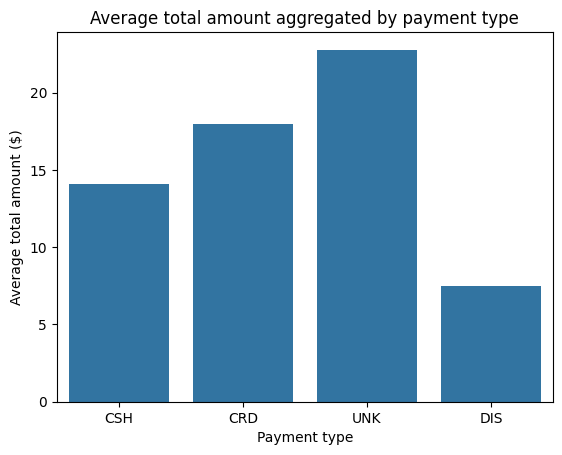

In [4]:
agg_df = df.groupBy("payment_type").agg(F.avg("total_amount").alias("avg_total_amount"))
print(f'{df.count()} rows reduced to {agg_df.count()} rows after aggregation.')

# convert to pandas for visualization
agg_df_pd = agg_df.toPandas()  # can only run this after the memory is downsized

# plot aggregated data
sns.barplot(data=agg_df_pd, x="payment_type", y="avg_total_amount")
plt.title("Average total amount aggregated by payment type")
plt.xlabel("Payment type")
plt.ylabel("Average total amount ($)")
plt.savefig('plots/avg-total-amt_by_pmt-type.png')
plt.show()

### Sampling
Sample the data -> convert to pandas -> plot

1542426 rows reduced to 154031 rows after sampling 10.0%.


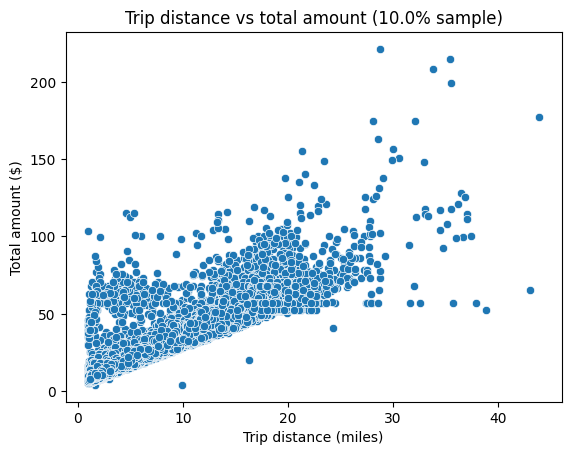

In [5]:
sample_size = 0.10
sample_df = df.sample(fraction=sample_size, seed=42)
print(f'{df.count()} rows reduced to {sample_df.count()} rows after sampling {sample_size*100}%.')

# convert to pandas for visualization
sample_df_pd = sample_df.toPandas()  # can only run this after the memory is downsized

# plot sampled data
sns.scatterplot(data=sample_df_pd, x="trip_distance", y="total_amount")
plt.title(f"Trip distance vs total amount ({sample_size*100}% sample)")
plt.xlabel("Trip distance (miles)")
plt.ylabel("Total amount ($)")
plt.savefig(f'plots/trip-dist_vs_total-amt_{sample_size*100}%-sample.png')
plt.show()

1542426 rows reduced to 771771 rows after sampling 50.0%.


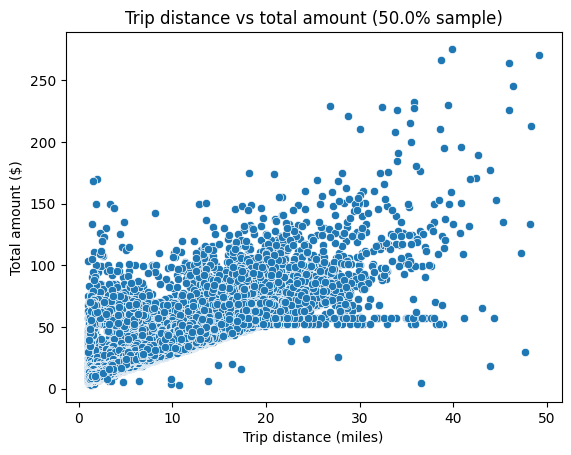

In [6]:
sample_size = 0.50
sample_df = df.sample(fraction=sample_size, seed=42)
print(f'{df.count()} rows reduced to {sample_df.count()} rows after sampling {sample_size*100}%.')

# convert to pandas for visualization
sample_df_pd = sample_df.toPandas()  # can only run this after the memory is downsized

# plot sampled data
sns.scatterplot(data=sample_df_pd, x="trip_distance", y="total_amount")
plt.title(f"Trip distance vs total amount ({sample_size*100}% sample)")
plt.xlabel("Trip distance (miles)")
plt.ylabel("Total amount ($)")
plt.savefig(f'plots/trip-dist_vs_total-amt_{sample_size*100}%-sample.png')
plt.show()

## Method 2: big data visualization
Visualize without reducing data volume

### Dask df -> Datashader
Datashader works only on pandas or dask dataframe
- Dask dataframe is distributed, better for big data than pandas
- Datashader rasterizes: compresses all data points into pixels based on density

In [7]:
import dask.dataframe as dd

In [8]:
columns = ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime',
           'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latidue',
           'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
           'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']

df_dask = dd.read_csv(DATA_FILE, names=columns, blocksize=None)
df_dask.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latidue,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,07290D3599E7A0D62097A346EFCC1FB5,E7750A37CAB07D0DFF0AF7E3573AC141,2013-01-01 00:00:00,2013-01-01 00:02:00,120,0.44,-73.956528,40.716976,-73.962440,40.715008,CSH,3.5,0.5,0.5,0.0,0.0,4.5
1,22D70BF00EEB0ADC83BA8177BB861991,3FF2709163DE7036FCAA4E5A3324E4BF,2013-01-01 00:02:00,2013-01-01 00:02:00,0,0.00,0.000000,0.000000,0.000000,0.000000,CSH,27.0,0.0,0.5,0.0,0.0,27.5
2,0EC22AAF491A8BD91F279350C2B010FD,778C92B26AE78A9EBDF96B49C67E4007,2013-01-01 00:01:00,2013-01-01 00:03:00,120,0.71,-73.973145,40.752827,-73.965897,40.760445,CSH,4.0,0.5,0.5,0.0,0.0,5.0
3,1390FB380189DF6BBFDA4DC847CAD14F,BE317B986700F63C43438482792C8654,2013-01-01 00:01:00,2013-01-01 00:03:00,120,0.48,-74.004173,40.720947,-74.003838,40.726189,CSH,4.0,0.5,0.5,0.0,0.0,5.0
4,3B4129883A1D05BE89F2C929DE136281,7077F9FD5AD649AEACA4746B2537E3FA,2013-01-01 00:01:00,2013-01-01 00:03:00,120,0.61,-73.987373,40.724861,-73.983772,40.730995,CRD,4.0,0.5,0.5,0.0,0.0,5.0


In [9]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.utils import export_image

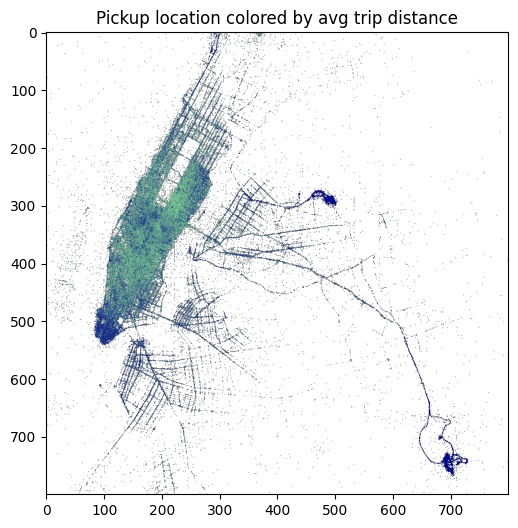

Light green = shorter trips
Dark blue = longer trips


In [10]:
canvas = ds.Canvas(plot_width=800, plot_height=800,
                   x_range=(-74.05, -73.75), y_range=(40.63, 40.85))  # NYC approx coordinates

agg = canvas.points(df_dask, 'pickup_longitude', 'pickup_latidue', agg=ds.mean('trip_distance'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'])

plt.figure(figsize=(8,6))
plt.imshow(img.to_pil())   # Datashader image
plt.title("Pickup location colored by avg trip distance")
plt.savefig(f'plots/pickup-loc_by_avg-trip-dist.png')
plt.show()
print('Light green = shorter trips\nDark blue = longer trips')

# End

In [11]:
spark.stop()